In [0]:
from google.colab import drive
drive.mount('/content/gdrive')
driveProjectDir = '/content/gdrive/My Drive/DeepLearning/Assignment_05_part2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import multilabel_confusion_matrix

## **DATA LOADING**

In [0]:
train_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.RandomRotation(30),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])


data_dir = driveProjectDir+ "/Dataset"
#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train'    ,  transform=train_transforms )
test_data = datasets.ImageFolder(data_dir + '/Test'      ,  transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation' , transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 50, shuffle=True )
testloader  = torch.utils.data.DataLoader(test_data, batch_size  = 50, shuffle = False )
valloader   = torch.utils.data.DataLoader(val_data, batch_size   =50, shuffle=True)

class_names = train_data.classes
print(" Required Classes: ", ', '.join(class_names))

 Required Classes:  covid-19, normal, pneumonia


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


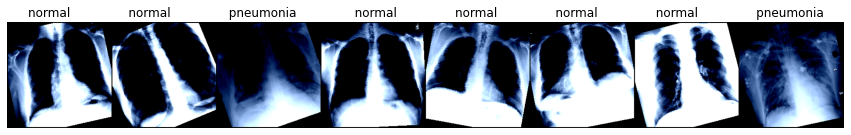

In [0]:
#****************************************************************Visualization of Loaded Data************************************888
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.01)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    plt.figure(figsize=(15,8))
    imshow(out, title='               '.join([class_names[x] for x in classes]))

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs[:8], classes[:8])

## **FUNCTIONS**

In [0]:
#************************************************************************************
#                      One hot Encoding
#************************************************************************************

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
def one_hot_encoding(classesinfo, label):
  label  = label.cpu().numpy()
  y = np.zeros((label.shape[0], len(classesinfo)))
  y[np.arange(label.shape[0]), label] = 1
  covid_index = classesinfo.index("covid-19")
  pneum_index = classesinfo.index("pneumonia")
  for o in y:
    if int(o[covid_index]) == 1:
      o[pneum_index] = 1

  return torch.tensor(y).to(device) 

def one_hot_decoding(classesinfo, label):
  label  = label.cpu().numpy()
  covid_index = classesinfo.index("covid-19")
  pneum_index = classesinfo.index("pneumonia")
  normal_index = classesinfo.index("normal")
 
  output = []
  for o in label:
    
    if (int(o[covid_index]) == 1) : #and int(o[pneum_index]==1)  :
      output.append(covid_index)
    elif(int(o[pneum_index]) == 1):
      output.append(pneum_index)
    elif(int(o[normal_index]) == 1):
      output.append(normal_index)
    else:
      output.append(np.random.randint(3))

  return torch.tensor(output).to(device) 



In [0]:
#************************************************************************************
#                      Focal Loss
#************************************************************************************
def FocalLoss(y_pred, y_true , gamma = 2 , alpha = 0.24) : 
    t = one_hot_encoding(class_names,y_true)
    #sig_layer = nn.Sigmoid()
    #p = sig_layer(y_pred)
    #pt = p*t + (1-p)*(1-t)
    BCE = torch.nn.functional.binary_cross_entropy_with_logits(y_pred , t , reduction='none')
    pt = torch.exp(-BCE)
    
    fC = - torch.mean((alpha*(1-pt)**(gamma))*torch.log(pt))
    return fC

In [0]:
#************************************************************************************
#                      Model Prediction Function
#************************************************************************************
def predtionFunc(y ):
  with torch.no_grad():  
    sig_layer = nn.Sigmoid()
    sig_out = sig_layer(y)
    pred    = sig_layer(y)

    sig_out[sig_out>0.5] =1
    sig_out[sig_out<0.5] = 0
    #print(sig_out)
    predicted =  one_hot_decoding(class_names, sig_out)
    p = torch.sum(sig_out, dim=1)
    n = list(p.cpu().numpy())
    if 0 in n :
      ind = n.index(0)
      _,l =  torch.max(pred[ind] , 0)
      sig_out[ind][l] = 1
      predicted[ind] = l
    
    #del sig_out,pred ,p 

    return predicted ,sig_out

In [0]:
#************************************************************************************
#                       Model Train Function
#************************************************************************************
def TrainModel(model ,trainingDataLoader,ValidationDataLoader , datapath , Loss = None , Epochs = 10, lr = 0.001, momentum= 0.9  ):

  criterion = nn.BCEWithLogitsLoss()
  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

  model.to(device)
  model.train()


  LogData = {}
  LogData['Epochs'] = []
  LogData["Loss"] = {'train' : [] , 'val': []}
  LogData["Accuracy"] = {'train' : [] , 'val': []}

  for epoch in range(Epochs):  # loop over the dataset multiple times
      print("*********************** Epoch ",epoch, " ***************************************")
      #********************************* Train Data**********************************************
      running_loss = 0.0
      batches_number = 0
      correct = 0
      total = 0
      correct1 = 0
      pbar = tqdm(enumerate(trainingDataLoader), position=0, leave=True)
      for i, data in pbar:

          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          encoded_labels = one_hot_encoding(class_names, labels)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs) 
          if(Loss == 'FocalLoss'):
            loss = FocalLoss(outputs, labels)
          else:
            loss = criterion(outputs ,encoded_labels )

          loss.backward()                       #----> backward pass
          optimizer.step()                      #----> weights update

          # print statistics
          running_loss += loss.item()
          pbar.set_description(
              'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, i * len(inputs), len(trainingDataLoader.dataset),
                  100. * i / len(trainingDataLoader),
                  loss.data.item()))

          
          predicted ,_ =  predtionFunc(outputs.data )
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          
          batches_number = i

      LogData["Loss"]["train"].append(np.round((running_loss/(batches_number+1)),decimals=4))
      LogData["Accuracy"]["train"].append(np.round((100 * correct / total),decimals=4))
      
      #********************************* Validation Data**********************************************
      running_loss = 0.0
      batches_number = 0
      correct = 0
      total = 0

      for i, data in enumerate(ValidationDataLoader):
          # get the inputs
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          encoded_labels = one_hot_encoding(class_names, labels)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = model(inputs)  
                      #----> forward pass
          if(Loss == 'FocalLoss'):              #----> forward pass
            loss = FocalLoss(outputs, labels)
          else:
            
            loss = criterion(outputs ,encoded_labels )
          
          running_loss += loss.item()
          batches_number = i

          #accuracy
          predicted,_  = predtionFunc(outputs.data)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      LogData["Epochs"].append(epoch)
      LogData["Loss"]["val"].append(np.round((running_loss/(batches_number+1)),decimals=4))
      LogData["Accuracy"]["val"].append(np.round((100 * correct / total),decimals=4))
      
      print("*******************************************************************************")
      print("Loss: \n Train Data:"      ,LogData["Loss"]["train"][epoch], "\t Validation Data:" , LogData["Loss"]["val"][epoch] )
      print("Accuracy: \n Train Data:"      ,LogData["Accuracy"]["train"][epoch], "\t Validation Data:" , LogData["Accuracy"]["val"][epoch] )

      #Saving Model and LogData   
      #torch.save(model.state_dict(), driveProjectDir+datapath+'.pth')
      torch.save(model, driveProjectDir+datapath+'.pth')
      
      f = open(driveProjectDir+datapath+'_log.txt' ,mode='w')
      f.write(str(LogData))
      f.close()

  plt.figure(figsize=(15,4))
  plt.subplot(1,2,1)
  plt.gca().set(title='Loss Curve over epochs', ylabel='Loss', xlabel='epochs')            
  plt.plot(LogData['Epochs'],LogData["Loss"]["train"] , label="Train")
  plt.plot(LogData['Epochs'],LogData["Loss"]["val"] , label="Validation")
  plt.legend()

  plt.subplot(1,2,2) 
  plt.gca().set(title='Accuracy Curve over epochs', ylabel='Accuracy', xlabel='epochs')            
  plt.plot(LogData['Epochs'],LogData["Accuracy"]['train'] , label="Train")
  plt.plot(LogData['Epochs'],LogData["Accuracy"]['val'] , label="Validation")
  plt.legend()

  plt.savefig(driveProjectDir+datapath+ "_plot.png")



In [0]:
#************************************************************************************
#                      Evaluate Model 
#************************************************************************************
def printConfusion_Matrix(c , classes_info , title):
  plt.pause(0.01)
  plt.figure()
  ax= plt.subplot()
  sns.heatmap(c, annot=True, ax = ax  ,cmap='Greens' ,fmt='g');

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title(title); 
  ax.xaxis.set_ticklabels(classes_info); ax.yaxis.set_ticklabels(classes_info);



def modelEvaluate(model, DataLoader):

  #  if torch.cuda.is_available():
  #      model.cuda()

  correct = 0
  total = 0
  predlist=torch.zeros(0,dtype=torch.long, device='cpu')
  labelslist=torch.zeros(0,dtype=torch.long, device='cpu')

  e_predlist = []  #=torch.zeros(0,dtype=torch.long, device='cpu')
  e_labelslist =  []#  =torch.zeros(0,dtype=torch.long, device='cpu')
  acc = 0
  fscore = 0

  with torch.no_grad():
      pbar = tqdm(enumerate(DataLoader), position=0, leave=True)
      batches = 0
      for i , data in pbar:

        images, labels = data
        images, labels = images.to(device), labels.to(device)
        encoded_labels = one_hot_encoding(class_names, labels)
        
        outputs = model(images)

        predicted  , e_predicted = predtionFunc(outputs.data )
        predlist=torch.cat([predlist,predicted.view(-1).cpu()])
        labelslist=torch.cat([labelslist,labels.view(-1).cpu()])
        #print(e_predicted)
        for item in e_predicted.cpu().numpy():
            e_predlist.append(item)

        for item in encoded_labels.cpu().numpy():
            e_labelslist.append(item)

  
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        pbar.set_description(
              'Data Passed:  [{}/{} ({:.0f}%)]'.format(
                  i * len(inputs), len(DataLoader.dataset),
                  100. * i / len(DataLoader)
                  ))

  #conf_mat = confusion_matrix(labelslist.numpy(), predlist.numpy()) 
  e_labelslist = np.array(e_labelslist) 
  e_predlist = np.array(e_predlist) 

  conf_mat_multilabel = multilabel_confusion_matrix(e_labelslist, e_predlist) 
  printConfusion_Matrix(conf_mat_multilabel[class_names.index("covid-19")] , ['-ive','+ive'] , '0-index Label (Covid -19)' )
  printConfusion_Matrix(conf_mat_multilabel[class_names.index("normal")] , ['-ive','+ive'] ,    '1-index Label (Normal)')
  printConfusion_Matrix(conf_mat_multilabel[class_names.index("pneumonia")] , ['-ive','+ive']  , '2-index Label (Pneumonia)')
  plt.pause(0.1) 
  print(classification_report(e_labelslist, e_predlist, target_names=class_names))





##**VGG16**

>**Without Focal Loss**

In [0]:
vgg16_NL = models.vgg16(pretrained=True)
# Freeze training for all layers of Model
for param in vgg16_NL.features.parameters():
    param.require_grad = False

rollnumber_neurons = (16 * 10 )  + 100
num_features = vgg16_NL.classifier[0].in_features

newClassifierLayers = [nn.Linear(num_features, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers.extend([nn.Linear(rollnumber_neurons, len(class_names))])
vgg16_NL.classifier = nn.Sequential(*newClassifierLayers)
vgg16_NL = torch.load(driveProjectDir+'vgg16.pth')

#print(vgg16)

In [0]:
#trainedmodel = TrainModel(vgg16_NL , trainloader , valloader ,'vgg16_NL',None, 10 , 0.001,  0.9 )

Data Passed:  [600/628 (92%)]: : 13it [00:12,  1.00it/s]


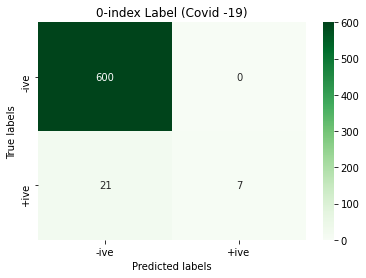

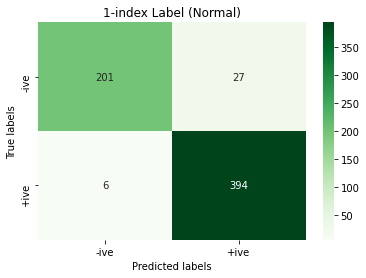

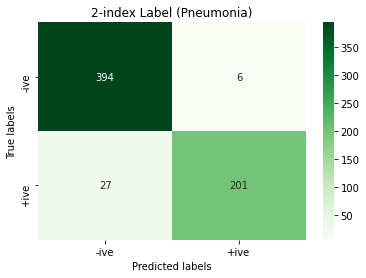

              precision    recall  f1-score   support

    covid-19       1.00      0.25      0.40        28
      normal       0.94      0.98      0.96       400
   pneumonia       0.97      0.88      0.92       228

   micro avg       0.95      0.92      0.93       656
   macro avg       0.97      0.71      0.76       656
weighted avg       0.95      0.92      0.92       656
 samples avg       0.95      0.94      0.94       656



In [0]:
modelEvaluate(vgg16_NL , valloader)

Data Passed:  [6150/6200 (99%)]: : 124it [12:12,  5.91s/it]


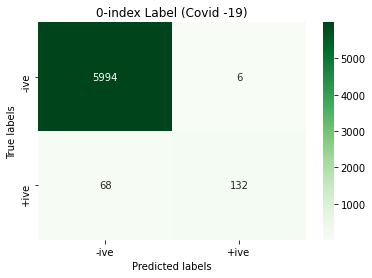

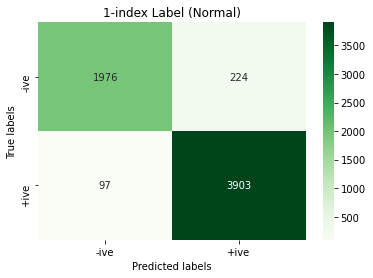

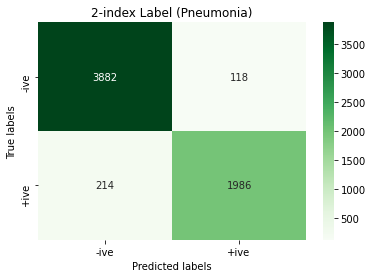

              precision    recall  f1-score   support

    covid-19       0.96      0.66      0.78       200
      normal       0.95      0.98      0.96      4000
   pneumonia       0.94      0.90      0.92      2200

   micro avg       0.95      0.94      0.94      6400
   macro avg       0.95      0.85      0.89      6400
weighted avg       0.95      0.94      0.94      6400
 samples avg       0.95      0.95      0.94      6400



In [0]:
modelEvaluate(vgg16_NL,trainloader)

>**With Focal Loss**

In [0]:
vgg16 = models.vgg16(pretrained=True)
# Freeze training for all layers of Model
for param in vgg16.features.parameters():
    param.require_grad = False

rollnumber_neurons = (16 * 10 )  + 100
num_features = vgg16.classifier[0].in_features

newClassifierLayers = [nn.Linear(num_features, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers.extend([nn.Linear(rollnumber_neurons, len(class_names))])
vgg16.classifier = nn.Sequential(*newClassifierLayers)
vgg16 = torch.load(driveProjectDir+'vgg16_focal_loss4.pth')

#print(vgg16)

In [0]:
#trainedmodel = TrainModel(vgg16 , trainloader , valloader ,'vgg16_focal_loss',FocalLoss, 10 , 0.0001,  0.9 )

Data Passed:  [600/628 (92%)]: : 13it [00:12,  1.01it/s]


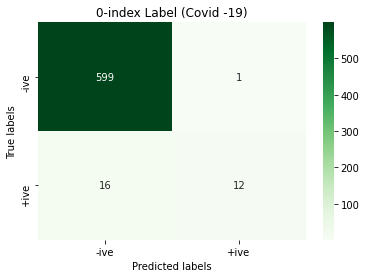

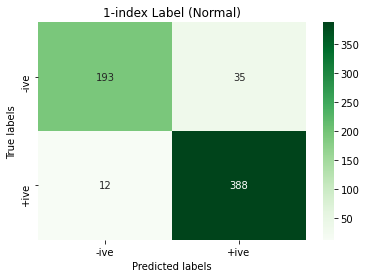

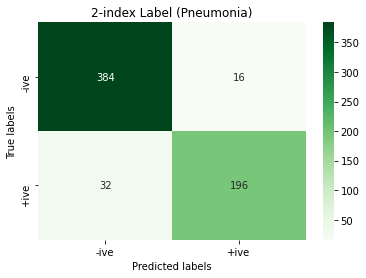

              precision    recall  f1-score   support

    covid-19       0.92      0.43      0.59        28
      normal       0.92      0.97      0.94       400
   pneumonia       0.92      0.86      0.89       228

   micro avg       0.92      0.91      0.91       656
   macro avg       0.92      0.75      0.81       656
weighted avg       0.92      0.91      0.91       656
 samples avg       0.92      0.92      0.92       656



In [0]:
modelEvaluate(vgg16,valloader)

Data Passed:  [6150/6200 (99%)]: : 124it [02:08,  1.04s/it]


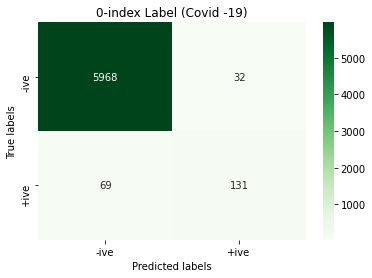

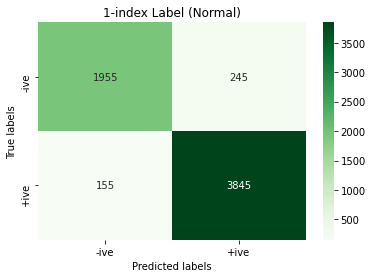

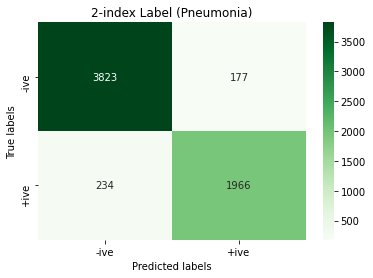

              precision    recall  f1-score   support

    covid-19       0.80      0.66      0.72       200
      normal       0.94      0.96      0.95      4000
   pneumonia       0.92      0.89      0.91      2200

   micro avg       0.93      0.93      0.93      6400
   macro avg       0.89      0.84      0.86      6400
weighted avg       0.93      0.93      0.93      6400
 samples avg       0.93      0.93      0.93      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
modelEvaluate(vgg16,trainloader)

##**Resnet18**

>**Without Focal Loss**

In [0]:
resnet18_NL = models.resnet18(pretrained=True)
for param in resnet18_NL.parameters():
    param.require_grad = False


rollnumber_neurons = (16 * 10 )  + 100
num_features_resnet = resnet18_NL.fc.in_features

newClassifierLayers_resnet = [nn.Linear(num_features_resnet, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers_resnet.extend([nn.Linear(rollnumber_neurons, len(class_names))])
resnet18_NL.fc = nn.Sequential(*newClassifierLayers_resnet)
resnet18_NL =torch.load(driveProjectDir+'res18.pth')
#print(resnet18)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


0it [00:00, ?it/s]

*********************** Epoch  0  ***************************************


Train Epoch: 0 [6150/6200 (99%)]	Loss: 0.359754: : 124it [02:02,  1.01it/s]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.4555 	 Validation Data: 0.3666
Accuracy: 
 Train Data: 66.0968 	 Validation Data: 82.3248
*********************** Epoch  1  ***************************************


Train Epoch: 1 [6150/6200 (99%)]	Loss: 0.235234: : 124it [02:03,  1.01it/s]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.2765 	 Validation Data: 0.2656
Accuracy: 
 Train Data: 84.5 	 Validation Data: 86.3057
*********************** Epoch  2  ***************************************


Train Epoch: 2 [6150/6200 (99%)]	Loss: 0.191508: : 124it [02:03,  1.00it/s]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.2101 	 Validation Data: 0.2178
Accuracy: 
 Train Data: 87.4839 	 Validation Data: 86.6242
*********************** Epoch  3  ***************************************


Train Epoch: 3 [6150/6200 (99%)]	Loss: 0.220960: : 124it [02:03,  1.01it/s]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1863 	 Validation Data: 0.2109
Accuracy: 
 Train Data: 88.5323 	 Validation Data: 88.2166
*********************** Epoch  4  ***************************************


Train Epoch: 4 [6150/6200 (99%)]	Loss: 0.245884: : 124it [02:03,  1.00it/s]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1795 	 Validation Data: 0.2118
Accuracy: 
 Train Data: 88.7419 	 Validation Data: 88.2166
*********************** Epoch  5  ***************************************


Train Epoch: 5 [6150/6200 (99%)]	Loss: 0.085931: : 124it [02:03,  1.01it/s]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1683 	 Validation Data: 0.1873
Accuracy: 
 Train Data: 89.2258 	 Validation Data: 88.3758
*********************** Epoch  6  ***************************************


Train Epoch: 6 [6150/6200 (99%)]	Loss: 0.112086: : 124it [02:05,  1.01s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1603 	 Validation Data: 0.1845
Accuracy: 
 Train Data: 89.5645 	 Validation Data: 89.172
*********************** Epoch  7  ***************************************


Train Epoch: 7 [6150/6200 (99%)]	Loss: 0.090103: : 124it [02:03,  1.01it/s]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1536 	 Validation Data: 0.1782
Accuracy: 
 Train Data: 90.0968 	 Validation Data: 88.535
*********************** Epoch  8  ***************************************


Train Epoch: 8 [6150/6200 (99%)]	Loss: 0.081783: : 124it [02:02,  1.01it/s]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.1475 	 Validation Data: 0.171
Accuracy: 
 Train Data: 90.371 	 Validation Data: 89.9682
*********************** Epoch  9  ***************************************


Train Epoch: 9 [6150/6200 (99%)]	Loss: 0.300239: : 124it [02:03,  1.01it/s]


*******************************************************************************
Loss: 
 Train Data: 0.1473 	 Validation Data: 0.1834
Accuracy: 
 Train Data: 90.6129 	 Validation Data: 88.6943


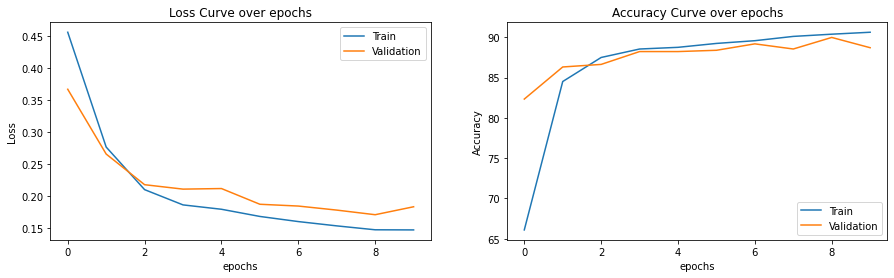

In [0]:
#trainedmodel = TrainModel(resnet18_NL , trainloader , valloader ,'res18',None, 10 , 0.0001,  0.9 )

Data Passed:  [600/628 (92%)]: : 13it [00:11,  1.11it/s]


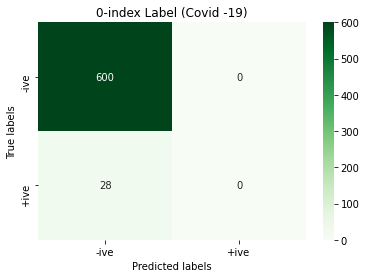

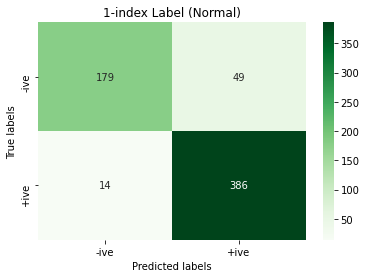

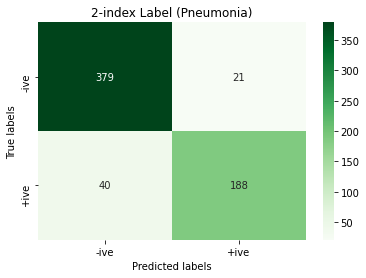

              precision    recall  f1-score   support

    covid-19       0.00      0.00      0.00        28
      normal       0.89      0.96      0.92       400
   pneumonia       0.90      0.82      0.86       228

   micro avg       0.89      0.88      0.88       656
   macro avg       0.60      0.60      0.59       656
weighted avg       0.85      0.88      0.86       656
 samples avg       0.90      0.90      0.90       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
modelEvaluate(resnet18_NL,valloader)

Data Passed:  [6150/6200 (99%)]: : 124it [01:55,  1.07it/s]


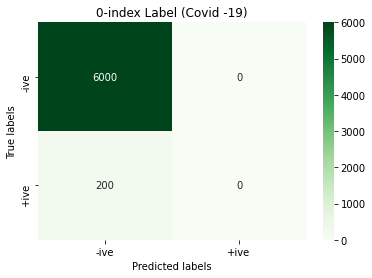

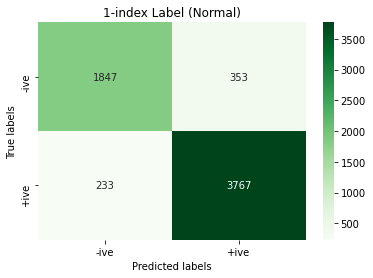

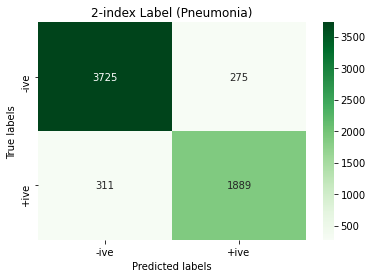

              precision    recall  f1-score   support

    covid-19       0.00      0.00      0.00       200
      normal       0.91      0.94      0.93      4000
   pneumonia       0.87      0.86      0.87      2200

   micro avg       0.90      0.88      0.89      6400
   macro avg       0.60      0.60      0.60      6400
weighted avg       0.87      0.88      0.88      6400
 samples avg       0.90      0.90      0.90      6400



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
modelEvaluate(resnet18_NL,trainloader)

>**With Focal Loss**

In [0]:
resnet18 = models.resnet18(pretrained=True)
for param in resnet18.parameters():
    param.require_grad = False


rollnumber_neurons = (16 * 10 )  + 100
num_features_resnet = resnet18.fc.in_features

newClassifierLayers_resnet = [nn.Linear(num_features_resnet, rollnumber_neurons) , nn.ReLU(inplace=True) , nn.Dropout(p =0.5)  ]
newClassifierLayers_resnet.extend([nn.Linear(rollnumber_neurons, len(class_names))])
resnet18.fc = nn.Sequential(*newClassifierLayers_resnet)
resnet18 =torch.load(driveProjectDir+'res18_focal_loss4.pth')
#print(resnet18)


0it [00:00, ?it/s]

*********************** Epoch  0  ***************************************


Train Epoch: 0 [6150/6200 (99%)]	Loss: 0.012049: : 124it [02:58,  1.44s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0134 	 Validation Data: 0.015
Accuracy: 
 Train Data: 87.2581 	 Validation Data: 85.9873
*********************** Epoch  1  ***************************************


Train Epoch: 1 [6150/6200 (99%)]	Loss: 0.013287: : 124it [02:59,  1.44s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0132 	 Validation Data: 0.0153
Accuracy: 
 Train Data: 87.1452 	 Validation Data: 86.9427
*********************** Epoch  2  ***************************************


Train Epoch: 2 [6150/6200 (99%)]	Loss: 0.020486: : 124it [03:00,  1.46s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0135 	 Validation Data: 0.0159
Accuracy: 
 Train Data: 87.2097 	 Validation Data: 87.2611
*********************** Epoch  3  ***************************************


Train Epoch: 3 [6150/6200 (99%)]	Loss: 0.016041: : 124it [03:00,  1.46s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0134 	 Validation Data: 0.0155
Accuracy: 
 Train Data: 87.2742 	 Validation Data: 86.9427
*********************** Epoch  4  ***************************************


Train Epoch: 4 [6150/6200 (99%)]	Loss: 0.008526: : 124it [03:00,  1.46s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0132 	 Validation Data: 0.0146
Accuracy: 
 Train Data: 87.3226 	 Validation Data: 87.1019
*********************** Epoch  5  ***************************************


Train Epoch: 5 [6150/6200 (99%)]	Loss: 0.015894: : 124it [03:00,  1.46s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0134 	 Validation Data: 0.0159
Accuracy: 
 Train Data: 87.0645 	 Validation Data: 87.1019
*********************** Epoch  6  ***************************************


Train Epoch: 6 [6150/6200 (99%)]	Loss: 0.013008: : 124it [02:59,  1.45s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0131 	 Validation Data: 0.0149
Accuracy: 
 Train Data: 87.8387 	 Validation Data: 87.2611
*********************** Epoch  7  ***************************************


Train Epoch: 7 [6150/6200 (99%)]	Loss: 0.011940: : 124it [02:59,  1.45s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0133 	 Validation Data: 0.0153
Accuracy: 
 Train Data: 87.629 	 Validation Data: 86.465
*********************** Epoch  8  ***************************************


Train Epoch: 8 [6150/6200 (99%)]	Loss: 0.012897: : 124it [02:59,  1.45s/it]
0it [00:00, ?it/s]

*******************************************************************************
Loss: 
 Train Data: 0.0132 	 Validation Data: 0.0151
Accuracy: 
 Train Data: 87.5 	 Validation Data: 86.7834
*********************** Epoch  9  ***************************************


Train Epoch: 9 [6150/6200 (99%)]	Loss: 0.013288: : 124it [02:59,  1.45s/it]


*******************************************************************************
Loss: 
 Train Data: 0.0131 	 Validation Data: 0.0153
Accuracy: 
 Train Data: 87.3065 	 Validation Data: 85.828


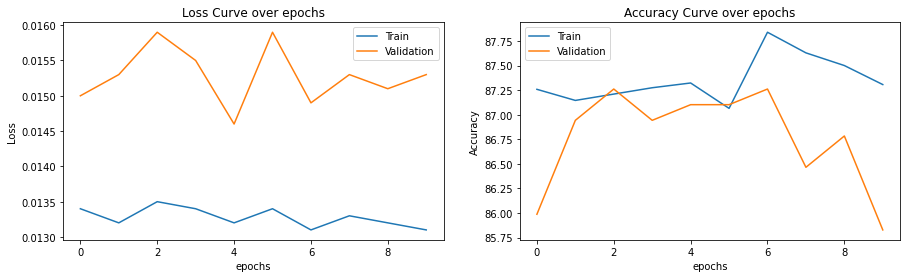

In [0]:
trainedmodel = TrainModel(resnet18 , trainloader , valloader ,'res18_focal_loss4','FocalLoss', 10 , 0.00001,  0.9 )

Data Passed:  [600/628 (92%)]: : 13it [00:11,  1.11it/s]


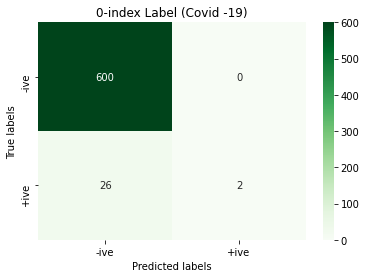

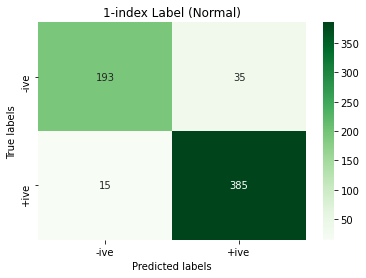

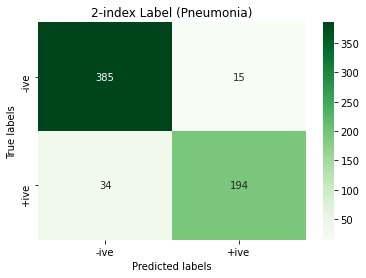

              precision    recall  f1-score   support

    covid-19       1.00      0.07      0.13        28
      normal       0.92      0.96      0.94       400
   pneumonia       0.93      0.85      0.89       228

   micro avg       0.92      0.89      0.90       656
   macro avg       0.95      0.63      0.65       656
weighted avg       0.92      0.89      0.89       656
 samples avg       0.92      0.91      0.91       656



In [0]:
modelEvaluate(resnet18,valloader)

Data Passed:  [6150/6200 (99%)]: : 124it [01:56,  1.07it/s]


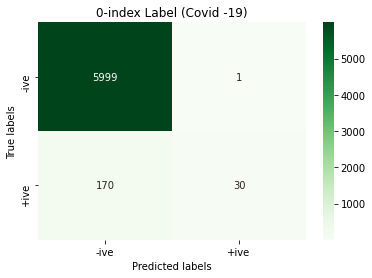

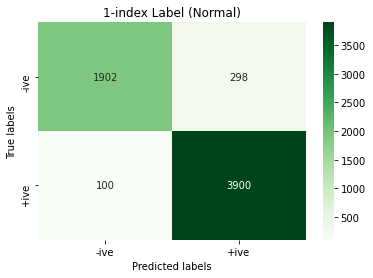

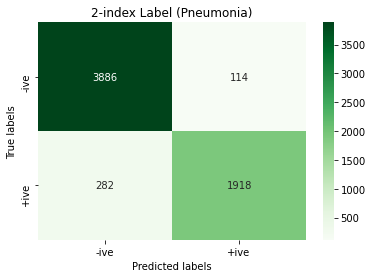

              precision    recall  f1-score   support

    covid-19       0.97      0.15      0.26       200
      normal       0.93      0.97      0.95      4000
   pneumonia       0.94      0.87      0.91      2200

   micro avg       0.93      0.91      0.92      6400
   macro avg       0.95      0.67      0.71      6400
weighted avg       0.94      0.91      0.91      6400
 samples avg       0.94      0.93      0.93      6400



In [0]:
modelEvaluate(resnet18,trainloader)

## **Test Data Prediction**

In [0]:

datadict = {'Image_Names' :[], 'Covid':[],'pneumonia':[],'normal':[]}
with torch.no_grad():
    for i, (images, labels) in enumerate(testloader):
        outputs = vgg16(images.to(device))
        predicted ,pred_encode = predtionFunc(outputs.data)
        batch_size = images.shape[0]
              
        for j in range(batch_size):
          item_num = i*batch_size +j  
          sample_fname, _ = testloader.dataset.samples[item_num]  
          image_name = sample_fname.split("/")[-1].split('.')[0]
          datadict['Image_Names'].append(image_name)
          datadict['Covid'].append(int(pred_encode[j][class_names.index("covid-19")].cpu().numpy())) 
          datadict['pneumonia'].append(int(pred_encode[j][class_names.index("pneumonia")].cpu().numpy()))
          datadict['normal'].append(int(pred_encode[j][class_names.index("normal")].cpu().numpy()))


In [0]:
df = pd.DataFrame(datadict)
df.to_csv(r'/content/gdrive/My Drive/DeepLearning/Assignment_05_part2/Results.csv' , index=False )
df.head()


,Image_Names,Covid,pneumonia,normal
0,0,0,0,1
1,1,0,0,1
2,10,0,0,1
3,100,0,1,0
4,101,0,0,1


In [0]:
#vgg16   without focal loss

#vgg16_focal_loss    with f1 loss 
#vgg16_focal_loss_F1      
      
      #vgg16_focal_loss2   with f2 loss  0.001
      #vgg16_focal_loss3   with f2 loss
      #vgg16_focal_loss4   with f2 loss
      #vgg16_focal_loss4   with f2 loss learning rate 0.0001